In [33]:
import stan

import nest_asyncio # https://pystan.readthedocs.io/en/latest/faq.html
nest_asyncio.apply()

In [34]:
# reload packages from notebook whenever needed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import arviz as az # For visualization and loo
import seaborn as sns 

# Code by hand

In [36]:
data = {'N': 100, 'y': 50} #number of trials, number of successes

`p_data_given_theta` : $P( y | \theta)$, i.e., the "data generating process"

`p_theta` : $P( \theta)$, i.e., the "prior"

`p_data` : $P( y )$, i.e., the "denominator" in Bayes rule.
Usually, we calculate this by breaking it down:

$P(y) =  \int P(y , \theta) d\theta =  \int P(y | \theta) P(\theta) d\theta$

In [48]:
def p_data_given_theta(theta, data):
    # there needs to be a combinatorial term here, but it doesn't cancel out
    
    # combinatorial_term = np.math.factorial(data['N']) / (np.math.factorial(data['y']) * np.math.factorial(data['N']-data['y']))
    # combinatorial_term
    
    return theta**data['y'] * (1-theta)**(data['N']-data['y'])

from scipy.stats import beta
def p_theta(theta):
    # beta(1, 1) prior, actually the uniform
    return beta.pdf(theta, 1, 1)

def p_data(data, possible_theta_values=np.linspace(0, 1, 1000), p_theta = p_theta):
    """
    This function is the marginal likelihood of the data.
    It is the integral of the likelihood function over possible values of theta, weighted by the prior.
    """
    unweighted_integral = np.sum([p_data_given_theta(theta, data) * p_theta(theta) for theta in possible_theta_values])
    integral = unweighted_integral / np.sum([p_theta(theta) for theta in possible_theta_values])
    return integral

What we care to calculate, i.e., the "posterior":

$P(\theta | y) = \frac{P(y | \theta) P(\theta)}{P(y)}$

In [49]:
possible_theta_values = np.linspace(0, 1, 1000) #theta is continuous but we can only calculate discrete values

In [50]:
def plot_posterior_given_data(data, p_theta = p_theta):
    denominator = p_data(data, possible_theta_values, p_theta = p_theta)
    p_theta_given_data = [p_data_given_theta(theta, data) * p_theta(theta) / denominator 
                        for theta in possible_theta_values]

    plt.plot(possible_theta_values, p_theta_given_data)
    plt.xlabel('$\\theta$')
    plt.ylabel('$p(\\theta|y)$')

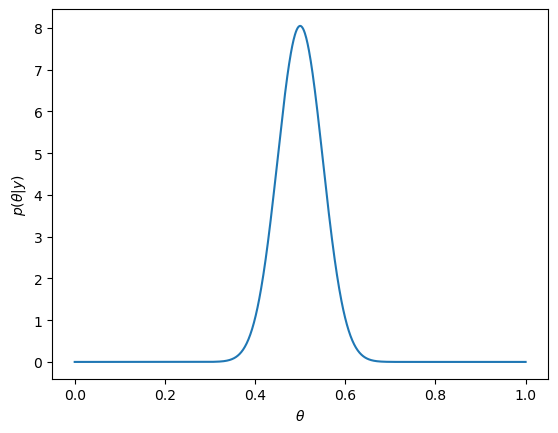

In [51]:
data = {'N': 100, 'y': 50} #number of trials, number of successes
plot_posterior_given_data(data)

Next, we see that if we have less data, our posterior is less concentrated ("more diffuse")

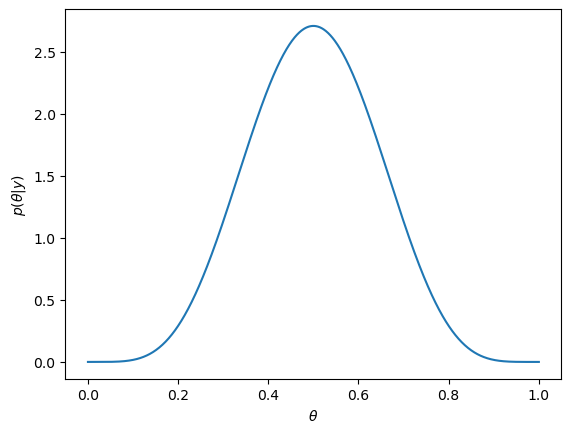

In [52]:
data = {'N': 10, 'y': 5} #number of trials, number of successes
plot_posterior_given_data(data)

What did our prior look like? Uniform distribution (A Beta(1, 1) is actually the uniform distribution). 

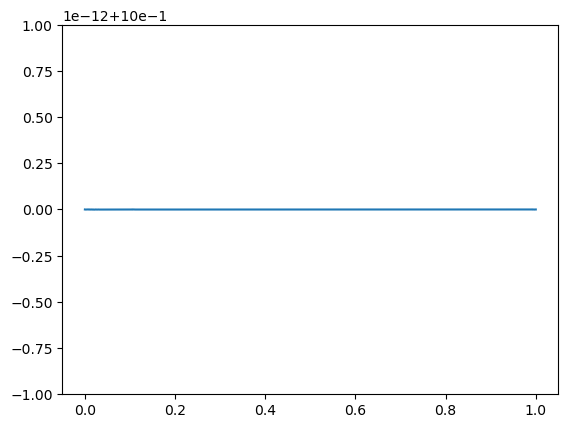

In [53]:
ptheta = [p_theta(theta) for theta in possible_theta_values]
plt.plot(possible_theta_values, ptheta)

A tighter prior concentrated around 0.5 would have been:

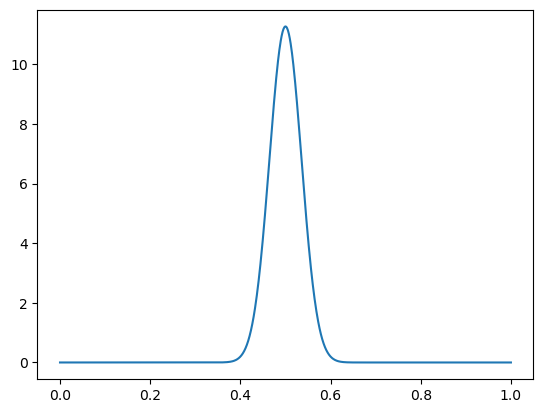

In [62]:
from scipy.stats import beta
def p_theta_tighter(theta):
    # beta(1, 1) prior
    return beta.pdf(theta, 100, 100)

ptheta = [p_theta_tighter(theta) for theta in possible_theta_values]
plt.plot(possible_theta_values, ptheta)

What if data was actually skewed? What would posterior look like?

In [58]:
data = {'N': 100, 'y': 10} #number of trials, number of successes

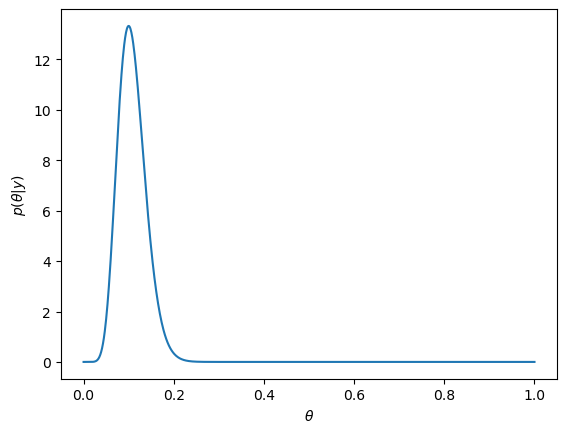

In [59]:
plot_posterior_given_data(data)

With a tighter prior, we don't move as close to 0 as with a diffuse prior

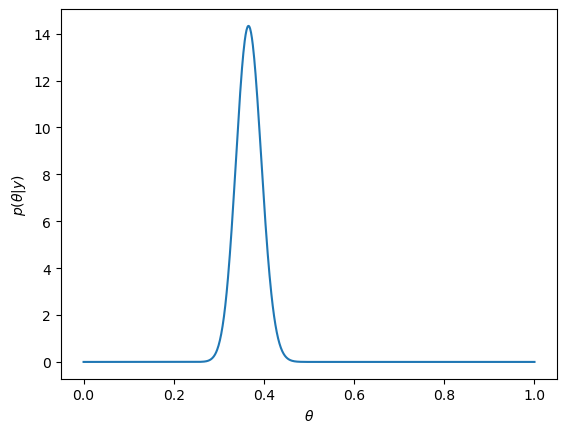

In [60]:
plot_posterior_given_data(data, p_theta = p_theta_tighter)

# Using Stan to fit a binomial model

In [13]:
stan_folder = 'stan_code/'
stan_file = stan_folder + 'binom.stan'
with open(stan_file) as file:
    model_code = file.read()
print(model_code)

// Binomial model with beta(1,1) prior
data {
  int<lower=0> N;
  int<lower=0> y;
}
parameters {
  real<lower=0,upper=1> theta;
}
model {
  theta ~ beta(1,1);
  y ~ binomial(N,theta);
}



In [14]:
stan_data = {'N': 100, 'y': 50} #number of trials, number of successes

In [15]:
compiled_model = stan.build(model_code, data=stan_data, random_seed=1)

Building...

In file included from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/multi_array/multi_array_ref.hpp:32,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/multi_array.hpp:34,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/numeric/odeint/algebra/multi_array_algebra.hpp:22,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/numeric/odeint.hpp:63,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/ode_rk45.hpp:9,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:14,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include


Building: 15.8s, done.Messages from stanc:


In [16]:
fit = compiled_model.sample(num_chains=2, num_warmup = 200, num_samples= 1000)


Sampling:   0%
Sampling:  50% (1200/2400)
Sampling: 100% (2400/2400)
Sampling: 100% (2400/2400), done.
Messages received during sampling:
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!


In [17]:
idata = az.from_pystan(posterior=fit, posterior_model=compiled_model)

In [18]:
summary = az.summary(fit)

In [19]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.497,0.049,0.41,0.595,0.002,0.001,657.0,995.0,1.0


<AxesSubplot: title={'center': 'theta'}>

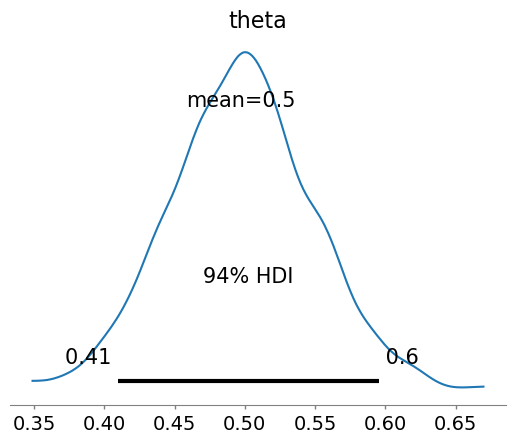

In [20]:
# Stan gives us _samples_ for theta, representing P(\theta | data)
az.plot_posterior(idata)

<AxesSubplot: xlabel='theta', ylabel='Count'>

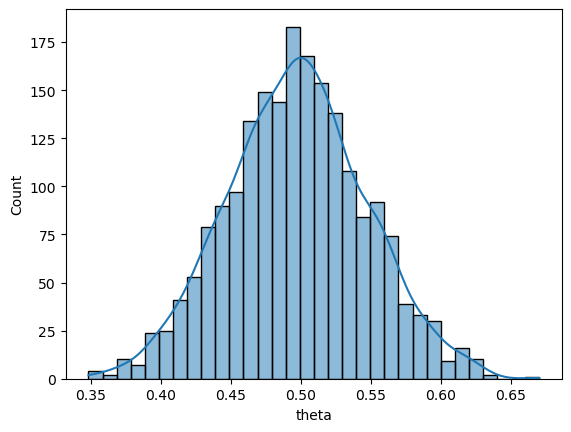

In [21]:
sns.histplot(data=az.extract(fit), x='theta', kde=True)

array([[<AxesSubplot: title={'center': 'theta'}>,
        <AxesSubplot: title={'center': 'theta'}>]], dtype=object)

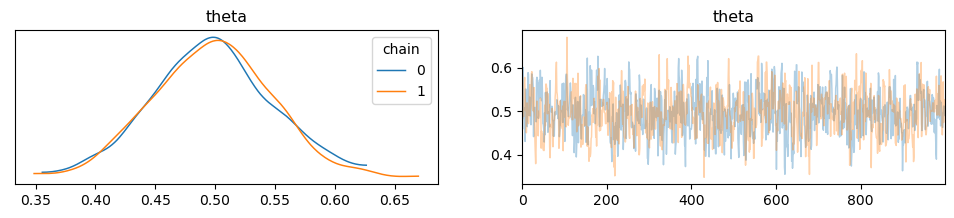

In [22]:
az.plot_trace(fit, compact=False, legend=True)